Running GridSearchCV for RFE (Wrapper Method)...

Cross-Validation Accuracy Scores: ['70.31%', '73.44%', '71.09%', '75.78%', '81.25%']
Mean CV Accuracy: 74.38%
Standard Deviation of CV Accuracy: 3.93%


--- RFE (Wrapper Method) Results ---
Features after VarianceThreshold: ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
Best parameters found: {'feature_selection__n_features_to_select': 7}
Selected Features: ['MCV', 'MCHC', 'HCT', 'RDW-CV', 'Diabetes', 'Age', 'Gender']

Accuracy: 77.50%
ROC AUC Score: 81.70%

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        80
           1       0.76      0.81      0.78        80

    accuracy                           0.78       160
   macro avg       0.78      0.78      0.77       160
weighted avg       0.78      0.78      0.77       160


Predictions saved to predictions_rfe_method.csv

Training class distribution:
 H

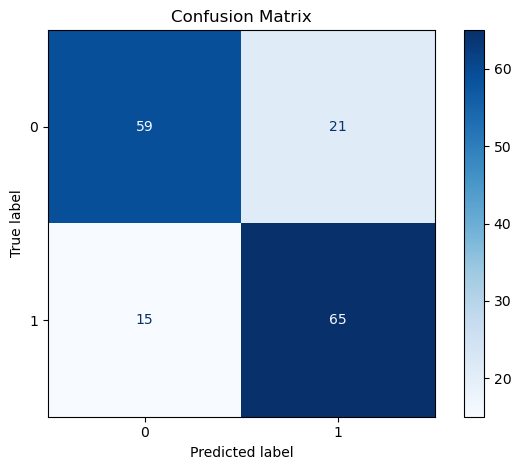

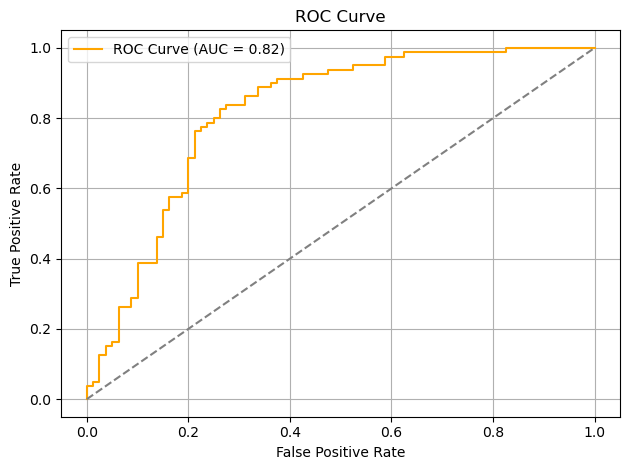

In [9]:
#LR

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia logic
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Feature selection
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

X = data_scaled
y = data['Heartdisease']

# Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# --- START OF MODIFIED SECTION FOR RFE (Wrapper Method) ---

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)


# Define the base estimator for RFE (e.g., Logistic Regression)
estimator_rfe = LogisticRegression(solver='liblinear')

# Define the RFE selector
selector_wrapper = RFE(estimator=estimator_rfe)

# Define the classifier
classifier_wrapper = LogisticRegression(max_iter=1000, random_state=42)

# Create a pipeline combining the feature selection and the classifier
pipeline_wrapper = Pipeline(steps=[
    ('feature_selection', selector_wrapper),
    ('classifier', classifier_wrapper)
])

# Use GridSearchCV to find the best number of features for RFE
# We'll test selecting different numbers of features.
param_grid_wrapper = {
    'feature_selection__n_features_to_select': np.arange(5, min(len(features_kept), 11))
}

print("Running GridSearchCV for RFE (Wrapper Method)...")
grid_search_wrapper = GridSearchCV(pipeline_wrapper, param_grid_wrapper, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_wrapper.fit(X_train_df, y_train)

# Get the best pipeline from the grid search
best_pipeline_rfe = grid_search_wrapper.best_estimator_

from sklearn.model_selection import cross_val_score

# Calculate cross-validation accuracy scores using the best pipeline
cv_accuracy_scores = cross_val_score(best_pipeline_rfe, X_train_df, y_train, cv=5, scoring='accuracy', n_jobs=-1)

mean_cv_accuracy = np.mean(cv_accuracy_scores) * 100
std_cv_accuracy = np.std(cv_accuracy_scores) * 100

print(f"\nCross-Validation Accuracy Scores: {[f'{score * 100:.2f}%' for score in cv_accuracy_scores]}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}%")
print(f"Standard Deviation of CV Accuracy: {std_cv_accuracy:.2f}%\n")

best_params_rfe = grid_search_wrapper.best_params_

# Extract selected features for printing
selected_features_indices = best_pipeline_rfe.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]

print("\n--- RFE (Wrapper Method) Results ---")
print(f"Features after VarianceThreshold: {features_kept}")
print(f"Best parameters found: {best_params_rfe}")
print(f"Selected Features: {selected_features}\n")


# Predict using the final best pipeline
predicted_proba = best_pipeline_rfe.predict_proba(X_test_df)[:, 1]
predicted_proba_percent = predicted_proba * 100
predicted_class = (predicted_proba >= 0.5).astype(int)

# --- END OF MODIFIED SECTION ---

# Evaluation
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

# Round accuracy and ROC AUC for printing to nearest whole number
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Predictions DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

# Enrich with original features
predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})
predictions_df['Anemia_Severity'] = data.loc[X_test.index, 'Anemia_Severity']
predictions_df['Anemia'] = data.loc[X_test.index, 'Anemia']

# Save predictions
predictions_df.to_csv('predictions_rfe_method.csv')
print("\nPredictions saved to predictions_rfe_method.csv")


# Class distribution
print("\nTraining class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_class)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues')  # Blue color map
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC = {roc_auc:.2f})')  # ROC in orange
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Total dataset size: 800
Missing target values: 0
Features kept after removing constant features: ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']

--- Wrapper Method (RFE) with Tuned Decision Tree ---
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters for Wrapper Method: {'classifier__criterion': 'gini', 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 2, 'feature_selection__n_features_to_select': 5}
Best ROC AUC score from GridSearchCV: 0.7811
Selected features with Wrapper Method: ['MCV', 'MCH', 'HCT', 'RDW-CV', 'Age']
Accuracy: 0.72
ROC AUC Score: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.55      0.67        80
           1       0.67      0.90      0.77        80

    accuracy                           0.72       160
   macro avg       0.76      0.73      0.72       160
weighted av

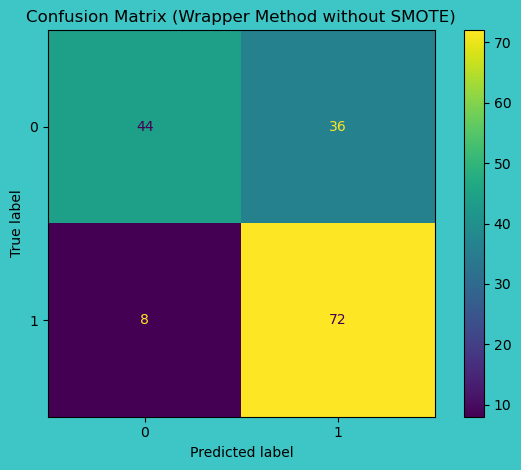

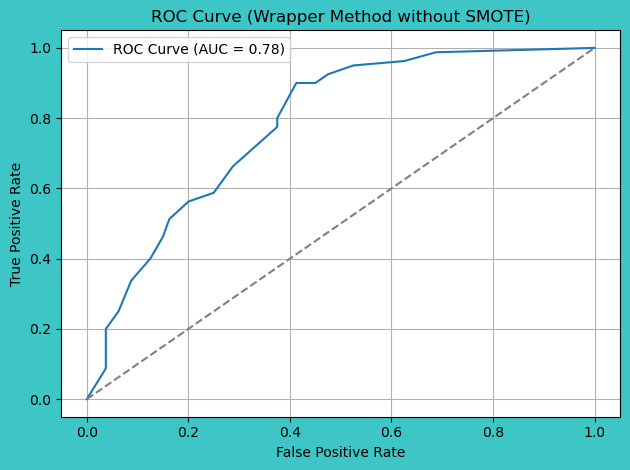

In [1]:
#DT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# Load data
data = pd.read_csv("actualdata.csv")

# Drop rows with missing target
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define anemia based on gender and age
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']

    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:  # age >= 12
        if gender == 0:  # Female
            return hb < 12.0
        elif gender == 1:  # Male
            return hb < 13.0
        else:
            return False  # handle unknown gender

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia severity classification
def classify_anemia_severity(hb, age, gender):
    # Determine threshold based on age and gender
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0

    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Normalize selected features for modeling
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Prepare features and target
X = data_scaled
y = data['Heartdisease']

print("Total dataset size:", len(data))
print("Missing target values:", data['Heartdisease'].isna().sum())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
print("Features kept after removing constant features:", features_kept)

# --- NO SMOTE: use original unbalanced data ---
X_train_balanced = X_train_var
y_train_balanced = y_train

print("\n--- Wrapper Method (RFE) with Tuned Decision Tree ---")

# Define the RFE selector, using a Decision Tree as the base estimator
selector_rfe = RFE(estimator=DecisionTreeClassifier(random_state=42))

# Define the final classifier
classifier_dt = DecisionTreeClassifier(random_state=42)

# Pipeline with RFE + Decision Tree classifier
pipeline_wrapper = Pipeline(steps=[
    ('feature_selection', selector_rfe),
    ('classifier', classifier_dt)
])

# Parameter grid for tuning
param_grid_wrapper = {
    'feature_selection__n_features_to_select': np.arange(5, 11),
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# GridSearchCV on unbalanced training data
grid_search_wrapper = GridSearchCV(
    pipeline_wrapper,
    param_grid_wrapper,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search_wrapper.fit(X_train_balanced, y_train_balanced)

print("Best parameters for Wrapper Method:", grid_search_wrapper.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_wrapper.best_score_:.4f}")

best_pipeline = grid_search_wrapper.best_estimator_

selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected features with Wrapper Method:", selected_features)

# Predict on test set
predicted_proba = best_pipeline.predict_proba(X_test_var)[:, 1]

# Convert probabilities to percentages
predicted_proba_percent = predicted_proba * 100

# threshold (keeping your specified threshold of 0.3)
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluate
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# DataFrame for predictions with original indexes
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

# Cholesterol, Diabetes, BP (convert 1/0 back to Yes/No)
predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})

# Add Anemia Severity descriptive label for test set
temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()

if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

temp_data_for_display['Anemia_Severity_Display'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
temp_data_for_display['Anemia_Display'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display['Anemia_Severity_Display']
predictions_df['Anemia'] = temp_data_for_display['Anemia_Display']

# Save predictions
predictions_df.to_csv('predictions_dt_rfe_no_smote.csv')
print("Predictions saved to predictions_dt_rfe_no_smote.csv")

# Print training/test class distribution for reference
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_class)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot and get the figure and axes
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')

disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Wrapper Method without SMOTE)")
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)

plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Wrapper Method without SMOTE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



--- Wrapper Method (RFE) with Tuned LightGBM (No SMOTE) ---
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 909
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters for Wrapper Method: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 100, 'classifier__num_leaves': 15, 'feature_selection__n_features_to_select': 10}
Best ROC AUC score from GridSearchCV: 0.7753
Selected Features: ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'Cholesterol', 'Age', 'Gender']
Accuracy: 0.74
ROC AUC Score: 0.80

Classification Report:
              precision    recall  f1-score   support



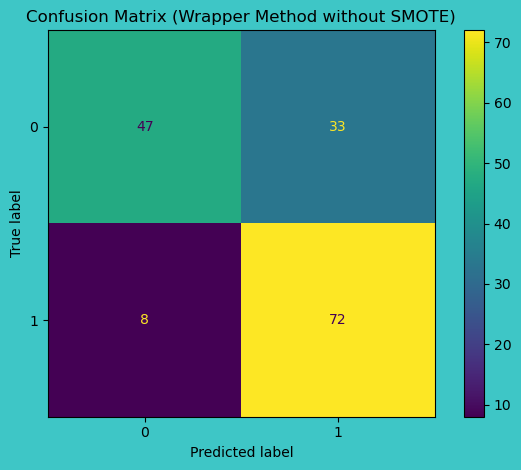

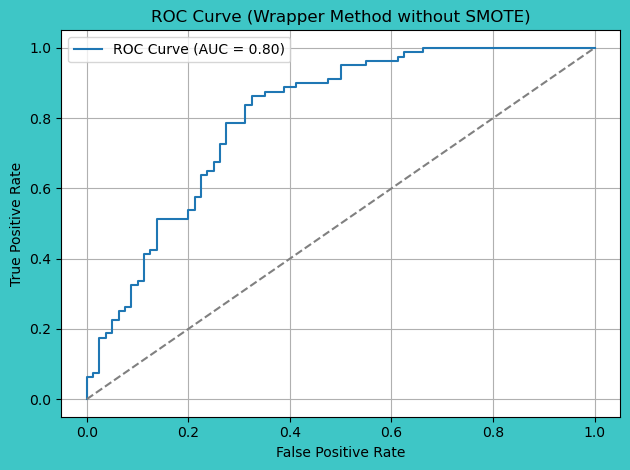

In [3]:
#Light GBM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, RFE
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier  # base estimator for RFE

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define Anemia function
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Classify severity
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']), axis=1
)

# Normalize features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Target
X = data_scaled
y = data['Heartdisease']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [f for f, keep in zip(features, var_thresh.get_support()) if keep]

X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# *** REMOVE SMOTE - use original unbalanced data ***
X_train_balanced = X_train_df
y_train_balanced = y_train

print("\n--- Wrapper Method (RFE) with Tuned LightGBM (No SMOTE) ---")

# RFE selector with DecisionTreeClassifier as base estimator
rfe_estimator = DecisionTreeClassifier(random_state=42)
selector_wrapper = RFE(estimator=rfe_estimator)

# Final LGBMClassifier for prediction
classifier_lgbm = LGBMClassifier(random_state=42)

# Pipeline
pipeline_wrapper = Pipeline(steps=[
    ('feature_selection', selector_wrapper),
    ('classifier', classifier_lgbm)
])

# Parameter grid
param_grid_wrapper = {
    'feature_selection__n_features_to_select': np.arange(5, 11),
    'classifier__n_estimators': [100, 200, 300],
    'classifier__num_leaves': [15, 31],
    'classifier__learning_rate': [0.05, 0.1]
}

grid_search_wrapper = GridSearchCV(
    pipeline_wrapper,
    param_grid_wrapper,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit without SMOTE
grid_search_wrapper.fit(X_train_balanced, y_train_balanced)

print("Best parameters for Wrapper Method:", grid_search_wrapper.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_wrapper.best_score_:.4f}")

best_pipeline = grid_search_wrapper.best_estimator_

selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected Features:", selected_features)

# Predict on test set
predicted_proba = best_pipeline.predict_proba(X_test_df)[:, 1]

predicted_proba_percent = predicted_proba * 100
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Save predictions
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)
predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})
predictions_df['Anemia_Severity'] = data.loc[X_test.index, 'Anemia_Severity']
predictions_df['Anemia'] = data.loc[X_test.index, 'Anemia']

predictions_df.to_csv('predictions_lightgbm_rfe_no_smote.csv')
print("Predictions saved to predictions_lightgbm_rfe_no_smote.csv")

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Wrapper Method without SMOTE)")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Wrapper Method without SMOTE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Total dataset size: 800
Missing target values: 0

--- Wrapper Method (RFE) with Tuned Random Forest (No SMOTE) ---
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters for Wrapper Method: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'feature_selection__n_features_to_select': 6}
Best ROC AUC score from GridSearchCV: 0.8103
Selected features with Wrapper Method: ['MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'Age']
Accuracy: 0.71
ROC AUC Score: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.49      0.63        80
           1       0.65      0.94      0.77        80

    accuracy                           0.71       160
   macro avg       0.77      0.71      0.70       160
weighted avg       0.77      0.71      0.70       160

Predictions saved to predictions_rf_rfe_no_smote.csv


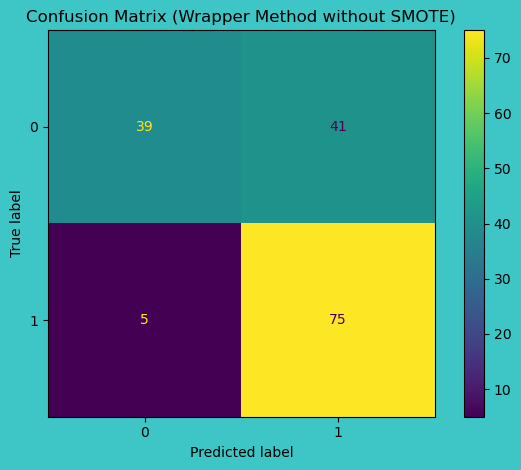

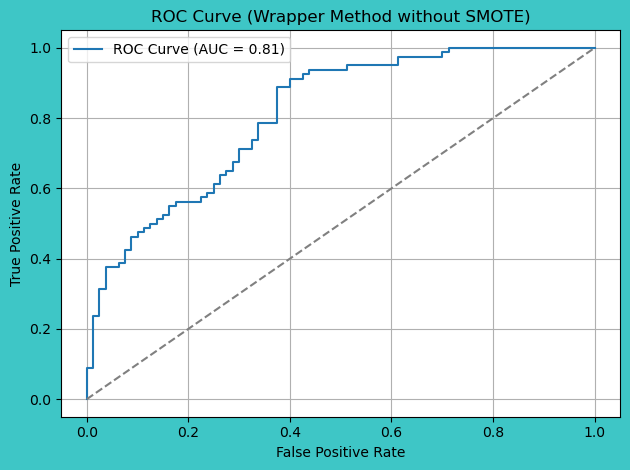

Number of patients with Anemia and Heart Disease: 297


In [5]:
#RF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier  # base estimator for RFE

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define anemia based on gender and age
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        if gender == 0:
            return hb < 12.0
        elif gender == 1:
            return hb < 13.0
        else:
            return False

data['Anemia'] = data.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Anemia severity classification
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Normalize selected features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Prepare features and target
X = data_scaled
y = data['Heartdisease']

print("Total dataset size:", len(data))
print("Missing target values:", data['Heartdisease'].isna().sum())

# Split data (without SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# --- START OF MODIFIED SECTION FOR WRAPPER METHOD (RFE) WITHOUT SMOTE ---
print("\n--- Wrapper Method (RFE) with Tuned Random Forest (No SMOTE) ---")

# Define RFE selector with DecisionTreeClassifier as base estimator
rfe_estimator = DecisionTreeClassifier(random_state=42)
selector_wrapper = RFE(estimator=rfe_estimator)

# Final RandomForestClassifier
classifier_rf = RandomForestClassifier(random_state=42)

# Pipeline
pipeline_wrapper = Pipeline(steps=[
    ('feature_selection', selector_wrapper),
    ('classifier', classifier_rf)
])

# Parameter grid
param_grid_wrapper = {
    'feature_selection__n_features_to_select': np.arange(5, 11),
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search_wrapper = GridSearchCV(
    pipeline_wrapper,
    param_grid_wrapper,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit on original imbalanced training data
grid_search_wrapper.fit(X_train_df, y_train)

print("Best parameters for Wrapper Method:", grid_search_wrapper.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_wrapper.best_score_:.4f}")

best_pipeline = grid_search_wrapper.best_estimator_

# Extract selected features
selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected features with Wrapper Method:", selected_features)

# Predict probabilities on test set
predicted_proba = best_pipeline.predict_proba(X_test_df)[:, 1]

predicted_proba_percent = predicted_proba * 100
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluate
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Prepare predictions dataframe
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

# Add categorical columns from original data for test set
temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()
if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

predictions_df['Cholesterol'] = temp_data_for_display['Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = temp_data_for_display['Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = temp_data_for_display['BP'].map({1: 'Yes', 0: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
predictions_df['Anemia'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Save predictions
predictions_df.to_csv('predictions_rf_rfe_no_smote.csv')
print("Predictions saved to predictions_rf_rfe_no_smote.csv")

# Confusion matrix
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Wrapper Method without SMOTE)")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Wrapper Method without SMOTE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Count patients with both Anemia and Heart Disease
anemia_and_hd = data[(data['Anemia'] == 'Yes') & (data['Heartdisease'] == 1)]
count_anemia_and_hd = anemia_and_hd.shape[0]
print(f"Number of patients with Anemia and Heart Disease: {count_anemia_and_hd}")


Total dataset size: 800
Missing target values: 0

--- Wrapper Method (RFE) with Tuned SVC ---
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for Wrapper Method: {'classifier__C': 100, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf', 'feature_selection__n_features_to_select': 5}
Best ROC AUC score from GridSearchCV: 0.8287
Selected Features: ['MCV', 'MCH', 'HCT', 'RDW-CV', 'Age']
Accuracy: 0.74
ROC AUC Score: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.54      0.67        80
           1       0.67      0.94      0.78        80

    accuracy                           0.74       160
   macro avg       0.78      0.74      0.73       160
weighted avg       0.78      0.74      0.73       160

Predictions saved to predictions_svm_rfe.csv
Training class distribution:
 Heartdisease
0    0.5
1    0.5
Name: proportion, dtype: float64
Test class distribution:
 Heartdisease
1    0.5
0    

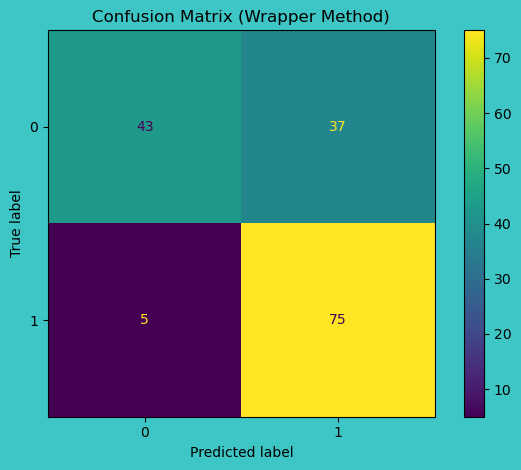

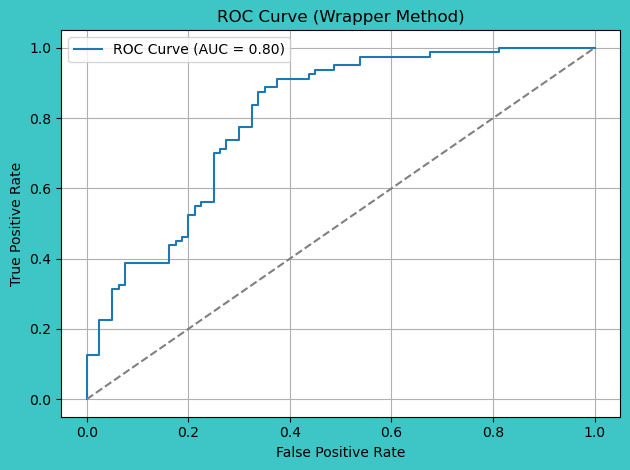

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define anemia
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Classify anemia severity
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']), axis=1
)

# Normalize features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Target and features
X = data_scaled
y = data['Heartdisease']

print("Total dataset size:", len(data))
print("Missing target values:", data['Heartdisease'].isna().sum())

# Split without SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [f for f, keep in zip(features, var_thresh.get_support()) if keep]
X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# --- START OF MODIFIED SECTION FOR WRAPPER METHOD (RFE) WITHOUT SMOTE ---
print("\n--- Wrapper Method (RFE) with Tuned SVC (No SMOTE) ---")

# Define RFE selector with DecisionTreeClassifier as base estimator
rfe_estimator = DecisionTreeClassifier(random_state=42)
selector_wrapper = RFE(estimator=rfe_estimator)

# Final SVC classifier
classifier_svc = SVC(probability=True, random_state=42)

# Pipeline
pipeline_wrapper = Pipeline(steps=[
    ('feature_selection', selector_wrapper),
    ('classifier', classifier_svc)
])

# Parameter grid
param_grid_wrapper = {
    'feature_selection__n_features_to_select': np.arange(5, 11),
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

grid_search_wrapper = GridSearchCV(
    pipeline_wrapper,
    param_grid_wrapper,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit on original training data
grid_search_wrapper.fit(X_train_df, y_train)

print("Best parameters for Wrapper Method:", grid_search_wrapper.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_wrapper.best_score_:.4f}")

best_pipeline = grid_search_wrapper.best_estimator_

# Extract selected features
selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected Features:", selected_features)

# Predict probabilities on test set
predicted_proba = best_pipeline.predict_proba(X_test_df)[:, 1]

predicted_proba_percent = predicted_proba * 100
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Output DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

# Re-fetch original categorical data for display
temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()
if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

predictions_df['Cholesterol'] = temp_data_for_display['Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = temp_data_for_display['Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = temp_data_for_display['BP'].map({1: 'Yes', 0: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
predictions_df['Anemia'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

predictions_df.to_csv('predictions_svm_rfe_no_smote.csv')
print("Predictions saved to predictions_svm_rfe_no_smote.csv")

# Confusion matrix
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Wrapper Method without SMOTE)")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Wrapper Method without SMOTE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



--- Wrapper Method (RFE) with Tuned XGBoost ---
Fitting 5 folds for each of 4374 candidates, totalling 21870 fits
Best parameters for Wrapper Method: {'classifier__colsample_bytree': 0.9, 'classifier__gamma': 0, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.7, 'feature_selection__n_features_to_select': 6}
Best ROC AUC score from GridSearchCV: 0.8066
Selected Features: ['MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'Age']
Accuracy: 0.72
ROC AUC Score: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.54      0.66        80
           1       0.66      0.90      0.76        80

    accuracy                           0.72       160
   macro avg       0.75      0.72      0.71       160
weighted avg       0.75      0.72      0.71       160

Predictions saved to predictions_xgboost_rfe.csv

Count of samples by Anemia Severity and Predicted Probability Range:

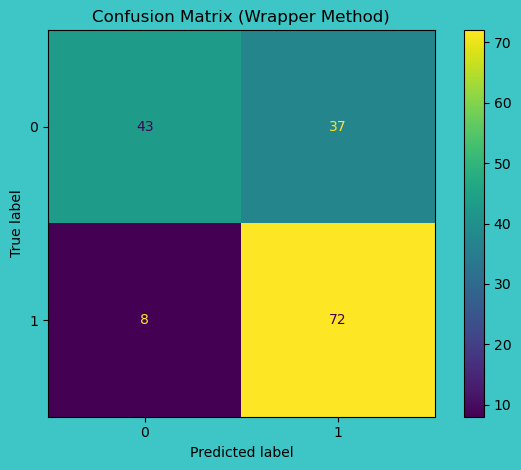

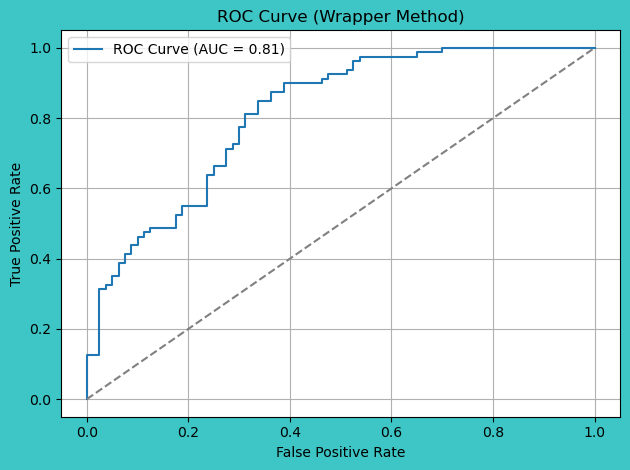

Number of patients with Anemia and Heart Disease: 297


In [2]:
#XGBoost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, RFE
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define Anemia
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Classify severity
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']), axis=1
)

# Normalize features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Target and features
X = data_scaled
y = data['Heartdisease']

# Split without SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [f for f, keep in zip(features, var_thresh.get_support()) if keep]
X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# --- START OF MODIFIED SECTION FOR WRAPPER METHOD (RFE) WITHOUT SMOTE ---
print("\n--- Wrapper Method (RFE) with Tuned XGBoost (No SMOTE) ---")

# Define the RFE selector with DecisionTreeClassifier as base estimator
rfe_estimator = DecisionTreeClassifier(random_state=42)
selector_wrapper = RFE(estimator=rfe_estimator)

# Final XGBoost classifier
classifier_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Pipeline
pipeline_wrapper = Pipeline(steps=[
    ('feature_selection', selector_wrapper),
    ('classifier', classifier_xgb)
])

# Parameter grid
param_grid_wrapper = {
    'feature_selection__n_features_to_select': np.arange(5, 11),
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1, 0.15],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__gamma': [0, 0.1, 0.2]
}

grid_search_wrapper = GridSearchCV(
    pipeline_wrapper,
    param_grid_wrapper,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit on original imbalanced training data
grid_search_wrapper.fit(X_train_df, y_train)

print("Best parameters for Wrapper Method:", grid_search_wrapper.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_wrapper.best_score_:.4f}")

best_pipeline = grid_search_wrapper.best_estimator_

# Extract selected features
selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected Features:", selected_features)

# Predict on test set
predicted_proba = best_pipeline.predict_proba(X_test_df)[:, 1]

predicted_proba_percent = predicted_proba * 100
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Output DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

# Re-fetch original categorical data for display
temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()
if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

predictions_df['Cholesterol'] = temp_data_for_display['Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = temp_data_for_display['Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = temp_data_for_display['BP'].map({1: 'Yes', 0: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
predictions_df['Anemia'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Optional: categorize predicted probabilities into bins
bins = [1, 20, 40, 60, 80, 100]
labels = ['1-20%', '21-40%', '41-60%', '61-80%', '81-100%']
predictions_df['Probability_Range'] = pd.cut(predictions_df['Predicted_Probability(%)'], bins=bins, labels=labels, include_lowest=True)

predictions_df.to_csv('predictions_xgboost_rfe_no_smote.csv')
print("Predictions saved to predictions_xgboost_rfe_no_smote.csv")

# Summary table
print("\nCount of samples by Anemia Severity and Predicted Probability Range:")
print(pd.crosstab(predictions_df['Anemia_Severity'], predictions_df['Probability_Range']))

print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Wrapper Method without SMOTE)")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Wrapper Method without SMOTE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Count patients with Anemia and Heart Disease
anemia_and_hd = data[(data['Anemia'] == 'Yes') & (data['Heartdisease'] == 1)]
print(f"Number of patients with Anemia and Heart Disease: {anemia_and_hd.shape[0]}")



--- Wrapper Method (RFE) for Feature Selection ---
Selected Features (RFE Method): ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'Age']
Best Threshold: 0.39, Best F1 Score: 0.7826

Final Ensemble Model Performance:
Accuracy: 75.00%
ROC AUC Score: 81.69%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        80
           1       0.69      0.90      0.78        80

    accuracy                           0.75       160
   macro avg       0.77      0.75      0.74       160
weighted avg       0.77      0.75      0.74       160

Predictions saved to 'ensemble_rfe_predictions.csv'


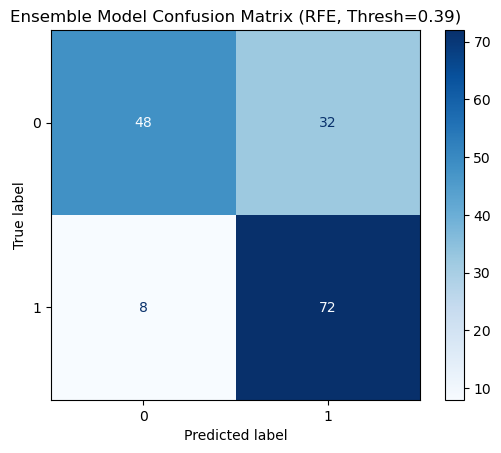

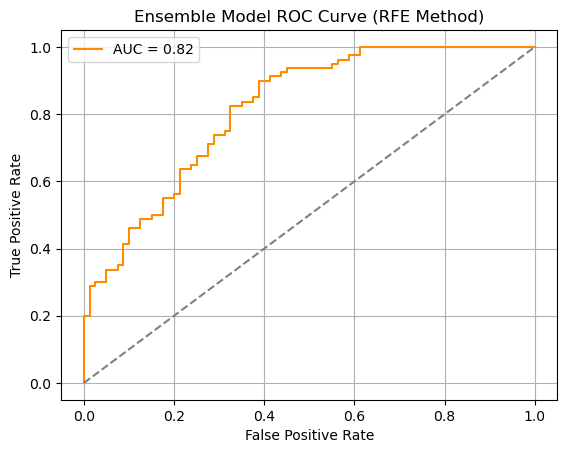

In [1]:
#ensemble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load and clean data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Encode BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia Detection
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia Severity
def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Select base features
base_features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
                 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
X = data[base_features]
y = data['Heartdisease']

# Scale only for LR and SVM
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=base_features)


# --- START OF MODIFIED SECTION FOR WRAPPER METHOD (RFE) ---
print("\n--- Wrapper Method (RFE) for Feature Selection ---")
# RFE needs a base estimator. A Decision Tree is a good, fast choice for this.
rfe_estimator = DecisionTreeClassifier(random_state=42)

# Use RFE to select the top 8 features (or another reasonable number)
# We choose a number slightly smaller than the total features to demonstrate selection.
# You could tune this number with a loop if needed.
num_features_to_select = 8
selector = RFE(estimator=rfe_estimator, n_features_to_select=num_features_to_select, step=1)
selector.fit(X_scaled, y)
X_selected = selector.transform(X_scaled)
selected_features = [base_features[i] for i in selector.get_support(indices=True)]
print(f"Selected Features (RFE Method): {selected_features}")
# --- END OF MODIFIED SECTION ---


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Tune models
param_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
param_rf = {'n_estimators': [100, 150], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}
param_svc = {'C': [0.1, 1, 2], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
param_lgbm = {'n_estimators': [100, 150, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]}
param_dt = {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']}

lr_search = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_lr, cv=3, n_iter=4,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=3, n_iter=5,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
svm_search = RandomizedSearchCV(SVC(probability=True, random_state=42), param_svc, cv=3, n_iter=5,
                                scoring='roc_auc', random_state=42, n_jobs=-1)
lgbm_search = RandomizedSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_lgbm, cv=3, n_iter=5,
                                 scoring='roc_auc', random_state=42, n_jobs=-1)
dt_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_dt, cv=3, n_iter=5,
                               scoring='roc_auc', random_state=42, n_jobs=-1)

lr_search.fit(X_train, y_train)
rf_search.fit(X_train, y_train)
svm_search.fit(X_train, y_train)
lgbm_search.fit(X_train, y_train)
dt_search.fit(X_train, y_train)

# XGBoost without early stopping
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_estimators=150,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8
)
xgb_model.fit(X_train, y_train)

# Ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_search.best_estimator_),
        ('rf', rf_search.best_estimator_),
        ('svm', svm_search.best_estimator_),
        ('xgb', xgb_model),
        ('lgbm', lgbm_search.best_estimator_),
        ('dt', dt_search.best_estimator_)
    ],
    voting='soft',
    n_jobs=-1
)
ensemble_model.fit(X_train, y_train)

# Predict probabilities and find best threshold
ensemble_proba = ensemble_model.predict_proba(X_test)[:, 1]

def find_best_threshold(y_true, y_probs):
    best_thresh = 0.5
    best_f1 = 0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (y_probs >= thresh).astype(int)
        score = f1_score(y_true, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh
    return best_thresh, best_f1

best_threshold, best_f1 = find_best_threshold(y_test, ensemble_proba)
print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.4f}")

# Final predictions
ensemble_preds = (ensemble_proba >= best_threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, ensemble_preds)
roc_auc = roc_auc_score(y_test, ensemble_proba)
print(f"\nFinal Ensemble Model Performance:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"ROC AUC Score: {roc_auc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, ensemble_preds, zero_division=0))

# Save results
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Anemia_Severity': data.loc[y_test.index, 'Anemia_Severity'],
    'Predicted_Probability(%)': ensemble_proba * 100,
    'Predicted_Class': ensemble_preds
}, index=y_test.index)
results_df.to_csv('ensemble_rfe_predictions.csv')
print("Predictions saved to 'ensemble_rfe_predictions.csv'")

# Confusion Matrix
cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Ensemble Model Confusion Matrix (RFE, Thresh={best_threshold:.2f})")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model ROC Curve (RFE Method)')
plt.legend()
plt.grid(True)
plt.show()

Selected Features using SelectFromModel: ['RBC', 'MCV', 'MCH', 'HCT', 'RDW-CV', 'Age']
Tuning Logistic Regression...
Tuning SVM...

Cross-Validation Accuracy Scores (Ensemble): [0.7109375 0.6796875 0.765625  0.765625  0.7890625]
Mean CV Accuracy (Ensemble): 74.22%
Standard Deviation: 4.04%
Best Threshold: 0.36, Best F1 Score: 0.7935

Final Ensemble Model Performance:
Accuracy: 76.25%
ROC AUC Score: 80.94%

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        80
           1       0.70      0.91      0.79        80

    accuracy                           0.76       160
   macro avg       0.79      0.76      0.76       160
weighted avg       0.79      0.76      0.76       160

Predictions saved to 'ensemble_model_predictions_anemia_optimized.csv'


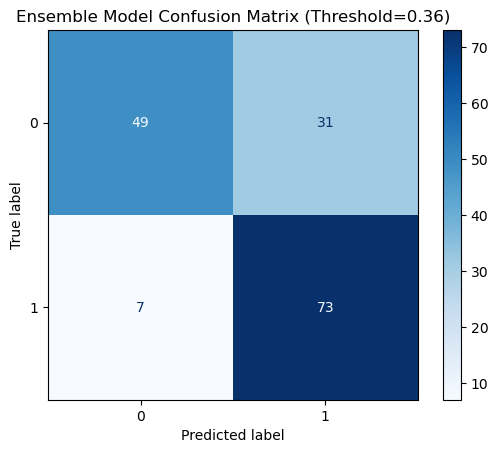

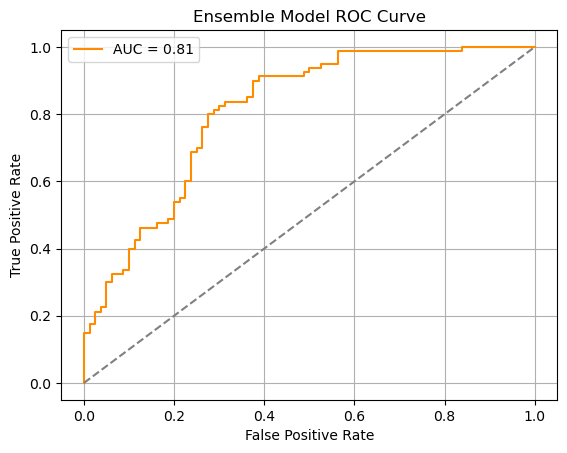

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load and clean data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Encode BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia Detection
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia Severity
def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Select base features
base_features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
                 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
X = data[base_features]
y = data['Heartdisease']

# Scale features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=base_features)

# Feature selection using SelectFromModel with RandomForestClassifier
selector_model = RandomForestClassifier(n_estimators=100, random_state=42)
selector_model.fit(X_scaled, y)

selector = SelectFromModel(estimator=selector_model, prefit=True, threshold='median')
X_selected = selector.transform(X_scaled)
selected_features = list(X_scaled.columns[selector.get_support()])

print(f"Selected Features using SelectFromModel: {selected_features}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter grids
param_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
param_svc = {'C': [0.1, 1, 2], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}

# Initialize models and RandomizedSearchCV for tuning
lr_search = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_lr, cv=3, n_iter=4,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
svm_search = RandomizedSearchCV(SVC(probability=True, random_state=42), param_svc, cv=3, n_iter=5,
                                scoring='roc_auc', random_state=42, n_jobs=-1)

# Fit tunings
print("Tuning Logistic Regression...")
lr_search.fit(X_train, y_train)

print("Tuning SVM...")
svm_search.fit(X_train, y_train)

# Build ensemble with tuned Logistic Regression and SVM
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_search.best_estimator_),
        ('svm', svm_search.best_estimator_),
    ],
    voting='soft',
    n_jobs=-1
)

# Fit ensemble
ensemble_model.fit(X_train, y_train)

# Cross-validation accuracy on training set
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy Scores (Ensemble): {cv_scores}")
print(f"Mean CV Accuracy (Ensemble): {cv_scores.mean()*100:.2f}%")
print(f"Standard Deviation: {cv_scores.std()*100:.2f}%")

# Predict probabilities on test set
ensemble_proba = ensemble_model.predict_proba(X_test)[:, 1]

# Find best threshold by maximizing F1 score
def find_best_threshold(y_true, y_probs):
    best_thresh = 0.5
    best_f1 = 0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (y_probs >= thresh).astype(int)
        score = f1_score(y_true, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh
    return best_thresh, best_f1

best_threshold, best_f1 = find_best_threshold(y_test, ensemble_proba)
print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.4f}")

# Final predictions using best threshold
ensemble_preds = (ensemble_proba >= best_threshold).astype(int)

# Evaluate final model
accuracy = accuracy_score(y_test, ensemble_preds)
roc_auc = roc_auc_score(y_test, ensemble_proba)
print(f"\nFinal Ensemble Model Performance:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"ROC AUC Score: {roc_auc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, ensemble_preds, zero_division=0))

# Save predictions with additional info
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Anemia_Severity': data.loc[y_test.index, 'Anemia_Severity'],
    'Predicted_Probability(%)': ensemble_proba * 100,
    'Predicted_Class': ensemble_preds
}, index=y_test.index)
results_df.to_csv('ensemble_model_predictions_anemia_optimized.csv')
print("Predictions saved to 'ensemble_model_predictions_anemia_optimized.csv'")

# Confusion Matrix plot
cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Ensemble Model Confusion Matrix (Threshold={best_threshold:.2f})")
plt.show()

# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, ensemble_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


Features selected by RFE: ['RBC', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Diabetes', 'Age', 'Gender']

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters found: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation ROC AUC: 0.8229

Cross-Validation Accuracy Scores: ['70.31%', '73.44%', '75.00%', '78.12%', '82.03%']
Mean CV Accuracy: 75.78%
Standard Deviation: 4.01%
Accuracy: 76.88%
ROC AUC Score: 81.83%

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        80
           1       0.74      0.82      0.78        80

    accuracy                           0.77       160
   macro avg       0.77      0.77      0.77       160
weighted avg       0.77      0.77      0.77       160


Predictions saved to predictions_tuned_logistic_rfe.csv

Training class distribution:
 Heartdisease
0    0.5
1    0.5
Name: proportion, dtype: float64
Test class distribution:
 Heartdisease

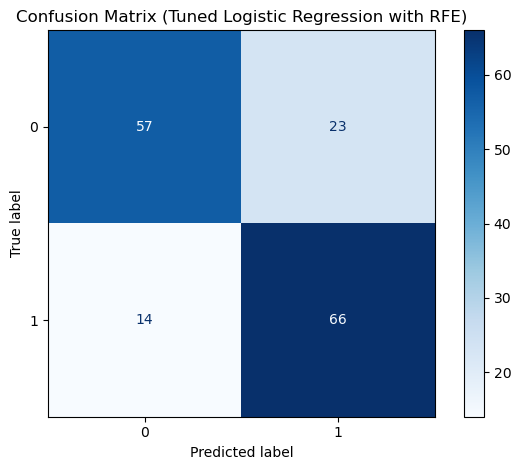

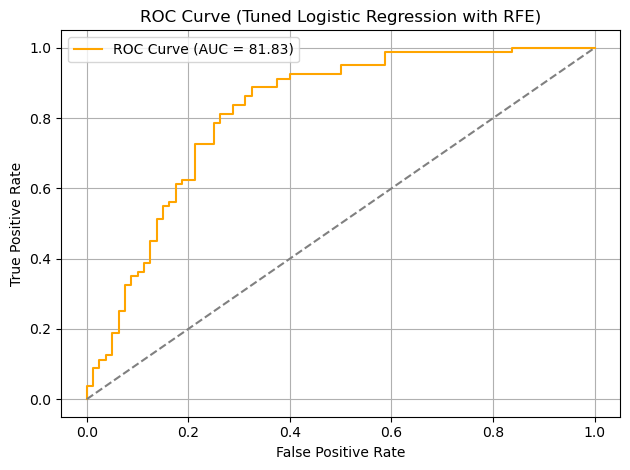

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.feature_selection import VarianceThreshold, RFE

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia logic
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Feature selection and scaling
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

X = data_scaled
y = data['Heartdisease']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
X_train_var_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_var_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# --- Feature selection using RFE ---
estimator = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Number of features to select, e.g. 10 or less if fewer features after variance threshold
n_features_to_select = min(10, X_train_var_df.shape[1])

selector = RFE(estimator=estimator, n_features_to_select=n_features_to_select)
selector.fit(X_train_var_df, y_train)

X_train_selected = selector.transform(X_train_var_df)
X_test_selected = selector.transform(X_test_var_df)

selected_features = [features_kept[i] for i in range(len(features_kept)) if selector.support_[i]]
print(f"Features selected by RFE: {selected_features}\n")

X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)

# --- Hyperparameter tuning with GridSearchCV ---
model = LogisticRegression(max_iter=1000, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_selected_df, y_train)

print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

# Cross-Validation Accuracy Scores on training set with best model
cv_accuracy_scores = cross_val_score(best_model, X_train_selected_df, y_train, cv=5, scoring='accuracy', n_jobs=-1)
cv_accuracy_percent = [f"{score * 100:.2f}%" for score in cv_accuracy_scores]
mean_cv_accuracy = np.mean(cv_accuracy_scores) * 100
std_cv_accuracy = np.std(cv_accuracy_scores) * 100

print(f"\nCross-Validation Accuracy Scores: {cv_accuracy_percent}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}%")
print(f"Standard Deviation: {std_cv_accuracy:.2f}%")

# Predict on test set
predicted_proba = best_model.predict_proba(X_test_selected_df)[:, 1]
predicted_class = (predicted_proba >= 0.5).astype(int)

# Evaluation on test set
accuracy = accuracy_score(y_test, predicted_class) * 100
roc_auc = roc_auc_score(y_test, predicted_proba) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"ROC AUC Score: {roc_auc:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Save predictions with original info
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba * 100
}, index=X_test.index)

predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})
predictions_df['Anemia_Severity'] = data.loc[X_test.index, 'Anemia_Severity']
predictions_df['Anemia'] = data.loc[X_test.index, 'Anemia']

predictions_df.to_csv('predictions_tuned_logistic_rfe.csv')
print("\nPredictions saved to predictions_tuned_logistic_rfe.csv")

# Class distribution
print("\nTraining class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

cm = confusion_matrix(y_test, predicted_class)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues')  # Blue color theme
plt.title("Confusion Matrix (Tuned Logistic Regression with RFE)")
plt.tight_layout()
plt.show()

# ROC Curve plot (orange line, white background)
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC = {roc_auc:.2f})')  # Orange line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Tuned Logistic Regression with RFE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
